In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tifffile as tif
import yaml
import os
import wandb
from pathlib import Path

import utils
import carreno.nn.metrics as mtc
import carreno.pipeline.pipeline
import carreno.processing.transforms as tfs
import carreno.utils.array
from carreno.nn.unet import UNet, encoder_trainable
from carreno.nn.generators import Generator
import carreno.processing.transforms as tfs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [ ]:
if not os.path.exists('config.yml'):
    os.chdir('..')

config = {}
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

inp_dir = config['VOLUME']['input']
tar_dir = config['VOLUME']['target']
wei_dir = config['VOLUME']['weight']
psf_dir = config['DIR']['psf']
mod_dir = config['DIR']['model']

psf = tif.imread(os.path.join(psf_dir, "Averaged PSF.tif"))
vx1 = tif.imread(os.path.join(inp_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vy1 = tif.imread(os.path.join(tar_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vw1 = tif.imread(os.path.join(wei_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vx2 = tif.imread(os.path.join(inp_dir, config['TRAINING']['evaluation'][1] + ".tif"))
vy2 = tif.imread(os.path.join(tar_dir, config['TRAINING']['evaluation'][1] + ".tif"))
vw2 = tif.imread(os.path.join(wei_dir, config['TRAINING']['evaluation'][1] + ".tif"))

ax1, __, __ = tfs.Standardize().apply(vx1)
ax2, __, __ = tfs.Standardize().apply(vx2)

input_shape = [192, 192, 3]
stride1 = list((vx1.shape[1:]) - np.array(input_shape[:-1])) + [3]
stride2 = list((vx2.shape[1:]) - np.array(input_shape[:-1])) + [3]

z = 8
dice         = mtc.Dice().coefficient
cldice3D     = mtc.ClDice(    iters=10, ndim=3, mode=2)
dicecldice3D = mtc.DiceClDice(iters=10, ndim=3, mode=2).coefficient
loss_fn      = mtc.ClDiceAdaptiveWingLoss(iters=10, ndim=3, mode=2).loss

def eval3D(x, y, w):
    tx = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), 0)
    ty = tf.expand_dims(tf.convert_to_tensor(y, dtype=tf.float32), 0)
    tw = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(w, dtype=tf.float32), 0), -1)
    dc    = dice        (tx, ty, tw)
    dcldc = dicecldice3D(tx, ty, tw)
    print("DC {}; DCLDC {}".format(dc, dcldc))

###############
# BUILD MODEL #
###############
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 192, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 192, 192, 64  36928       ['block1_conv1[1][0]']           
                                )           

cldice,▁
dice,▁
dicecldice,▁
epoch/cldice,▁▄▆▇█
epoch/dice,▁▅▇██
epoch/dicecldice,▁▅▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,█▆▄▂▁
epoch/loss,█▄▂▂▁
epoch/val_cldice,▂█▁▃▄
epoch/val_dice,▁█▁▁▅


###############
# SET LOADERS #
###############
Training dataset
-nb of instances : 96 / 96 / 96
Validation dataset
-nb of instances : 32 / 32 / 32
Testing dataset
-nb of instances : 32 / 32
Generator info
-length : 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-batch output shape : (16, 192, 192, 3) / (16, 192, 192, 3) / (16, 192, 192)
-batch visualization :


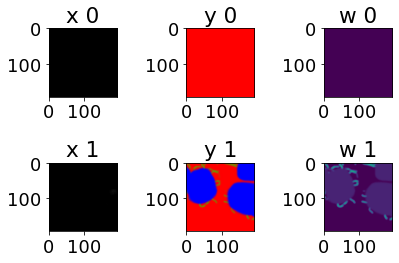

#############
# CALLBACKS #
#############
############
# TRAINING #
############
Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.8939 - dice: 0.4656 - cldice: 0.4282 - dicecldice: 0.4469
Epoch 1: val_dicecldice improved from -inf to 0.08830, saving model to data/output/model\unet2d_test.h5
6/6 [==============================] - 38s 6s/step - loss: 0.8939 - dice: 0.4656 - cldice: 0.4282 - dicecldice: 0.4469 - val_loss: 1.2041 - val_dice: 0.0169 - val_cldice: 0.1597 - val_dicecldice: 0.0883
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.6080 - dice: 0.6833 - cldice: 0.5429 - dicecldice: 0.6131
Epoch 2: val_dicecldice improved from 0.08830 to 0.31916, saving model to data/output/model\unet2d_test.h5
6/6 [==============================] - 32s 5s/step - loss: 0.6080 - dice: 0.6833 - cldice: 0.5429 - dicecldice: 0.6131 - val_loss: 0.8808 - val_dice: 0.2396 - val_cldice: 0.3987 - val_dicecldice: 0.3192
Epoch 3/5
6/6 [==============================] - ETA

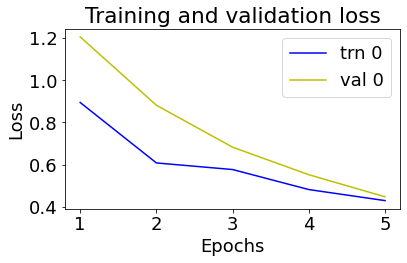

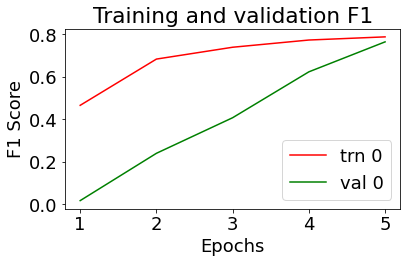

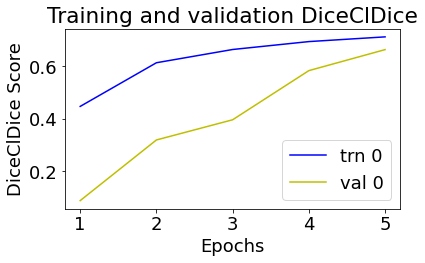

############
# EVALUATE #
############
2/2 [==============================] - 6s 871ms/step - loss: 0.3951 - dice: 0.7114 - cldice: 0.4985 - dicecldice: 0.6049


In [108]:
# adjustable settings
plt.rc('font', size=18)
out_model_name = "unet2d_test.h5"
out_model_dir  = config['DIR']['model']
wdb_project    = 'unet2d_test'
verbose = 1

params = {
    'ndim'     : 2,              # 2 or 3
    'shape'    : [1, 192, 192],  # data shape
    'depth'    : 4,              # unet depth
    'nfeat'    : 64,             # nb feature for first conv layer
    'lr'       : 0.001,          # learning rate
    'bsize'    : 16,             # batch size
    'nepoch'   : 5,            # number of epoch
    'scaler'   : 'stand',        # "norm" or "stand"
    'label'    : 'soft',         # hard or soft input
    'weight'   : True,           # use class weights for unbalanced data
    'order'    : 'after',        # where to put batch norm
    'ncolor'   : 3,              # color depth for input
    'act'      : 'relu',         # activation
    'loss'     : 'dicecldice',   # loss function
    'topact'   : 'softmax',      # top activation
    'dropout'  : 0.3,            # dropout rate
    'backbone' : 'vgg16',        # "unet" or "vgg16"
    'pretrn'   : True,           # pretrained encoder on imagenet
    'slftrn'   : False,          # pretrained encoder on unlabeled
    'dupe'     : 16              # nb d'usage pour un volume dans une époque
}

print("###############")
print("# BUILD MODEL #")
print("###############")

model = UNet(shape=params['shape'][1:] + [params['ncolor']],
             n_class=config['PREPROCESS']['n_cls'],
             depth=params['depth'],
             n_feat=params['nfeat'],
             dropout=params['dropout'],
             norm_order=params['order'],
             activation=params['act'],
             top_activation=params['topact'],
             backbone=None if params['backbone'] == "unet" else params['backbone'],
             pretrained=params['pretrn'])
model.summary()
# setup wandb
wandb.init(project=wdb_project, config=params)
print("###############")
print("# SET LOADERS #")
print("###############")
trn, vld, tst = utils.split_dataset(config['VOLUME']['input'])
fullpath = lambda dir, files : [os.path.join(dir, name) for name in files] * params['dupe']
hard_label = params['label'] == 'hard'
x_train = fullpath(config['VOLUME']['input'], trn)
y_train = fullpath(config['VOLUME']['target' if hard_label else 'soft_target'], trn)
w_train = fullpath(config['VOLUME']['weight' if hard_label else 'soft_weight'], trn) if params['weight'] else None
x_valid = fullpath(config['VOLUME']['input'],  vld)
y_valid = fullpath(config['VOLUME']['target' if hard_label else 'soft_target'], vld)
w_valid = fullpath(config['VOLUME']['weight' if hard_label else 'soft_weight'], vld) if params['weight'] else None
x_test  = fullpath(config['VOLUME']['input'],  tst)
y_test  = fullpath(config['VOLUME']['target'], tst)
unlabeled_vol = list(os.listdir(config['VOLUME']['unlabeled']))
fullpath = lambda dir, files : [os.path.join(dir, name) for name in files] * max(1, params['dupe'] // 4)
x_unlabeled_train = fullpath(config['VOLUME']['unlabeled'], unlabeled_vol)
y_unlabeled_train = fullpath(config['VOLUME']['unlabeled_target' if hard_label else 'unlabeled_soft_target'], unlabeled_vol)
w_unlabeled_train = fullpath(config['VOLUME']['unlabeled_weight' if hard_label else 'unlabeled_soft_weight'], unlabeled_vol) if params['weight'] else None

print("Training dataset")
if params['weight']:
    print("-nb of instances :", len(x_train), "/", len(y_train), "/", len(w_train))
else:
    print("-nb of instances :", len(x_train), "/", len(y_train))
print("Validation dataset")
if params['weight']:
    print("-nb of instances :", len(x_valid), "/", len(y_valid), "/", len(w_valid))
else:
    print("-nb of instances :", len(x_valid), "/", len(y_valid))
print("Testing dataset")
print("-nb of instances :", len(x_test), "/",  len(y_test))
if params['slftrn']:
    print("Training unlabeled dataset")
    if params['weight']:
        print("-nb of instances :", len(x_unlabeled_train), "/", len(y_unlabeled_train), "/", len(w_unlabeled_train))
    else:
        print("-nb of instances :", len(x_unlabeled_train), "/", len(y_unlabeled_train))
# setup data augmentation
train_aug, test_aug = utils.augmentations(shape=params['shape'],
                                          norm_or_std=True if params['scaler'] == 'norm' else False,
                                          is_2D=params['ndim'] == 2,
                                          n_color_ch=params['ncolor'])
# ready up the data generators
train_gen = Generator(x_train,
                      y_train,
                      weight=w_train if params['weight'] else None,
                      size=params['bsize'],
                      augmentation=train_aug,
                      shuffle=True)
valid_gen = Generator(x_valid,
                      y_valid,
                      weight=w_valid if params['weight'] else None,
                      size=params['bsize'],
                      augmentation=test_aug,
                      shuffle=False)  # make sure all patches fit in epoch
test_gen  = Generator(x_test,
                      y_test,
                      weight=None,
                      size=params['bsize'],
                      augmentation=test_aug,
                      shuffle=False)
train_unlabeled_gen = Generator(x_unlabeled_train,
                                y_unlabeled_train,
                                weight=w_unlabeled_train if params['weight'] else None,
                                size=params['bsize'],
                                augmentation=train_aug,
                                shuffle=True)

if verbose:
    print("Generator info")
    print("-length :", len(train_gen))
    
    batch0 = train_gen[0]
    print("-batch output shape :", batch0[0].shape, "/", batch0[1].shape, end="")
    if len(batch0) > 2:
        print(" /", batch0[2].shape)
    else:
        print()
    print("-batch visualization :")
    
    # cool visuals which are a joy to debug
    nb_columns = len(batch0)
    btc_size   = params['bsize']
    nb_lines   = min(btc_size, 2)
    for i in range(nb_lines):
        for j, k in zip(range(1, nb_columns+1), ['x', 'y', 'w']):
            one_input = batch0[j-1].numpy()
            plt.subplot(nb_lines, nb_columns, i*nb_columns+j)
            plt.title(k + " " + str(i))
            if params['ndim'] == 2:
                plt.imshow(one_input[i], vmin=one_input.min(), vmax=one_input.max())
            else:
                hslc = one_input[i].shape[0] // 2
                plt.imshow(one_input[i][hslc], vmin=one_input.min(), vmax=one_input.max())
    
    plt.tight_layout()
    plt.show()
print("#############")
print("# CALLBACKS #")
print("#############")
out_model_path = os.path.join(out_model_dir, out_model_name)
Path(out_model_dir).mkdir(parents=True, exist_ok=True)
# callbacks
monitor, mode = 'val_dicecldice', 'max'
patience = 10
early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                              mode=mode,
                                              patience=patience,
                                              restore_best_weights=True,
                                              verbose=1)
metrics_logger = wandb.keras.WandbMetricsLogger()
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=out_model_path,
                                                monitor=monitor,
                                                mode=mode,
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)

total_steps = len(train_gen) * params['nepoch']
schedule = tf.keras.optimizers.schedules.CosineDecay(params['lr'], decay_steps=total_steps)
optim = tf.keras.optimizers.Adam(learning_rate=schedule)
current_epoch = 0
iters = 10
ndim  = params['ndim']
pad   = 2
dice       = mtc.Dice()
cldice     = mtc.ClDice(    iters=iters, ndim=ndim, mode=pad)
dicecldice = mtc.DiceClDice(iters=iters, ndim=ndim, mode=pad)
if params['loss'] == "dice":
    loss_fn = dice.loss
elif params['loss'] == "dicecldice":
    loss_fn = dicecldice.loss
elif params['loss'] == "cedice":
    loss_fn = mtc.CeDice().loss
elif params['loss'] == "adawing":
    loss_fn = mtc.AdaptiveWingLoss().loss
elif params['loss'] == "cldiceadawing":
    loss_fn = mtc.ClDiceAdaptiveWingLoss(iters=iters, ndim=ndim, mode=pad).loss
else:
    raise NotImplementedError

def compile_n_fit(train_gen, valid_gen, start_epoch, log=True):
    model.compile(optimizer=optim,
                  loss=loss_fn,
                  weighted_metrics=[dice.coefficient, cldice.coefficient, dicecldice.coefficient],#metrics=[dice.coefficient, cldice.coefficient, dicecldice.coefficient],
                  sample_weight_mode="temporal", run_eagerly=True)

    callbacks = [early_stop] + ([checkpoint, metrics_logger] if log else [])
        
    hist = model.fit(train_gen,
                     validation_data=valid_gen,
                     steps_per_epoch=len(train_gen),
                     validation_steps=len(valid_gen),
                     batch_size=params['bsize'],
                     epochs=params['nepoch'],
                     initial_epoch=start_epoch,
                     callbacks=callbacks,
                     verbose=1)
    
    # save epoch history
    nb_epoch = len(hist.history['loss'])
    final_epoch = start_epoch + nb_epoch
    hist.history['epoch'] = list(range(start_epoch, final_epoch))
    
    return hist, final_epoch
graph_path = out_model_path.rsplit(".", 1)[0]
histories = []
if params['slftrn']:
    print("##############")
    print("# SELF-TRAIN #")
    print("##############")
    
    encoder_trainable(model, False)
    history_dec, current_epoch = compile_n_fit(train_unlabeled_gen,
                                               valid_gen,
                                               current_epoch)
    histories.append(history_dec)
print("############")
print("# TRAINING #")
print("############")
encoder_trainable(model, True)
history, current_epoch = compile_n_fit(train_gen,
                                       valid_gen,
                                       current_epoch)
histories.append(history)
utils.plot_metrics(graph_path, histories, verbose)
print("############")
print("# EVALUATE #")
print("############")
results = model.evaluate(test_gen, return_dict=True, verbose=1)
wandb.log(results)

In [111]:
threshold_unet2D = carreno.pipeline.pipeline.UNet2D(model)
sx1 = threshold_unet2D.segmentation(ax1, stride1)

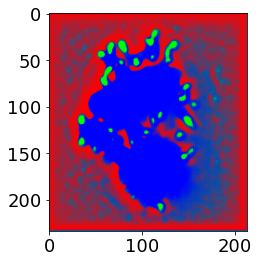

In [112]:
plt.imshow(sx1[8])
plt.show()